# GAN

### 1. Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции:

$$y = \frac{\sin(x)}{x}-\frac{x}{10}$$

При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Без графиков домашку не принимаю




In [50]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

torch.manual_seed(42)
rng = np.random.default_rng(42)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


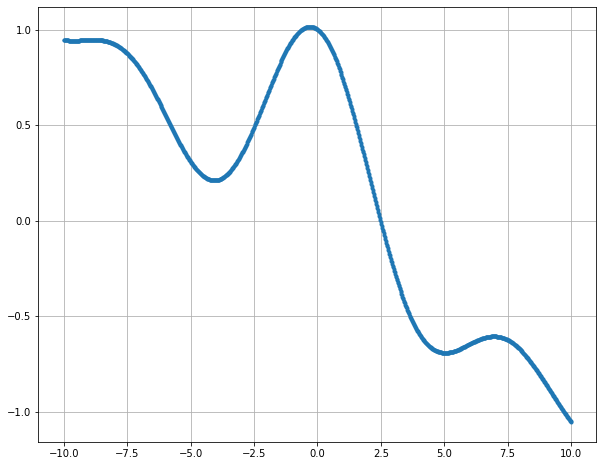

In [53]:
#Сгенерируем настоящие данные
train_data_length = 1024
start = -10
stop = 10
train_data = torch.zeros((train_data_length, 2))
x = np.linspace(start, stop, train_data_length)
np.random.shuffle(x)
train_data[:, 0] = torch.tensor(x, dtype=torch.float)
train_data[:, 1] = (torch.sin(train_data[:, 0])/train_data[:, 0])-(train_data[:, 0]/10)
train_labels = torch.zeros(train_data_length)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]

batch_size = 16
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

plt.figure(figsize=(10,8))
plt.plot(train_data[:, 0], train_data[:, 1], ".")
plt.grid() 
plt.show()  

Создание модели

In [54]:
# Генератор:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2))

    def forward(self, x):
        output = self.model(x)
        return output


# Дискриминатор:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, img):
        validity = self.model(img)
        return validity

Обучение

In [55]:
# Инициализация:
n_epochs = 1000 # количество эпох
lr = 0.0002 # шаг обучения

b1 = 0.5 # гиперпараметр для оптимайзера Adam
b2 = 0.999 # гиперпараметр для оптимайзера Adam

generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Но вот функция ошибки у нас будет одна общая
loss_function = torch.nn.BCELoss()

In [56]:
for epoch in tqdm(range(n_epochs)):
    for n, (real_samples, _) in enumerate(train_loader):
        # Данные для обучения дискриминатора
        real_samples = real_samples.to(device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device)
        latent_space_samples = torch.randn((batch_size, 2)).to(device)
        generated_samples = generator(latent_space_samples).to(device)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device)
        all_samples = torch.cat((real_samples, generated_samples)).to(device)
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels)).to(device)

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_D.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 2)).to(device)

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_G.step()

        # Выводим значения функций потерь
        if epoch % 100 == 0 and n == batch_size - 1:
            print(f"\nEpoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch: 0 Loss D.: 0.5966615676879883
Epoch: 0 Loss G.: 0.670982837677002


 10%|█         | 100/1000 [00:28<04:15,  3.53it/s]


Epoch: 100 Loss D.: 0.689834475517273
Epoch: 100 Loss G.: 0.6938236951828003


 20%|██        | 200/1000 [00:55<03:41,  3.61it/s]


Epoch: 200 Loss D.: 0.6888335943222046
Epoch: 200 Loss G.: 0.7028599977493286


 30%|███       | 300/1000 [01:24<03:13,  3.63it/s]


Epoch: 300 Loss D.: 0.7020784020423889
Epoch: 300 Loss G.: 0.6960536241531372


 40%|████      | 400/1000 [01:51<02:44,  3.64it/s]


Epoch: 400 Loss D.: 0.6926270723342896
Epoch: 400 Loss G.: 0.6878926753997803


 50%|█████     | 500/1000 [02:19<02:18,  3.62it/s]


Epoch: 500 Loss D.: 0.692240834236145
Epoch: 500 Loss G.: 0.6951548457145691


 60%|██████    | 600/1000 [02:47<01:52,  3.54it/s]


Epoch: 600 Loss D.: 0.6923755407333374
Epoch: 600 Loss G.: 0.700694739818573


 70%|███████   | 700/1000 [03:15<01:23,  3.58it/s]


Epoch: 700 Loss D.: 0.6928285360336304
Epoch: 700 Loss G.: 0.692961573600769


 80%|████████  | 800/1000 [03:43<00:55,  3.59it/s]


Epoch: 800 Loss D.: 0.6935456395149231
Epoch: 800 Loss G.: 0.7047799825668335


 90%|█████████ | 900/1000 [04:11<00:27,  3.57it/s]


Epoch: 900 Loss D.: 0.6945067048072815
Epoch: 900 Loss G.: 0.6937074661254883


100%|██████████| 1000/1000 [04:39<00:00,  3.58it/s]


Проверка образцов, сгенерированных GAN

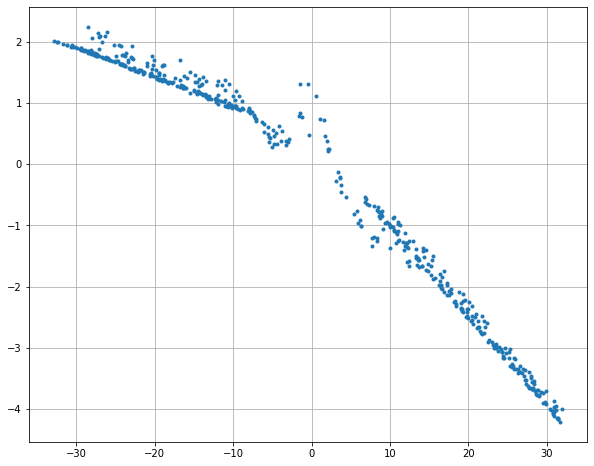

In [57]:
length = 1000
x = np.linspace(start, stop, length)
np.random.shuffle(x)
latent_space_samples = torch.tensor(x.reshape((length // 2), 2), dtype=torch.float).to(device)

generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach().cpu()


plt.figure(figsize=(10,8))
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")
plt.grid() 
plt.show()  